# Sensor Characterization Analysis
This notebook contains analysis for 6 sensor characterization experiments:
1. Normal force response
2. Shear response and directionality
3. Contact localization
4. Noise floor and resolution
5. Drift and temperature sensitivity
6. Version/material comparison

**Data columns:**
- `t`: timestamp
- `b1-b6`: barometer readings (6 channels)
- `x, y`: position
- `fx, fy, fz`: force components
- `tx, ty, tz`: torque components

In [8]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")

Libraries imported successfully!


---
## 1) Normal Force Response
**Experiment:** Press at fixed central location with 3-5 repeats, ramp 0 to 10 N and back.

**Plots:**
- Mean pressure (average of b1-b6) vs Fz with loading/unloading curves
- Sensitivity: slope dP/dFz in 0-2 N and 2-10 N (bar plot)
- Repeatability: overlay of 3-5 runs

In [9]:
# === DATA LOADING ===
# Modify this path to your normal force response dataset
data_path_1 = r"C:\Users\aurir\OneDrive - epfl.ch\Thesis- Biorobotics Lab\train_validation_test_data\train_data_v5.1091.csv"

# Load data
df1 = pd.read_csv(data_path_1)
print(f"Loaded {len(df1)} samples")
print(f"Data range: Fz from {df1['fz'].min():.2f} to {df1['fz'].max():.2f} N")
df1.head()

Loaded 448 samples
Data range: Fz from -16.07 to 0.02 N


,t,b1,b2,b3,b4,b5,b6,x,y,fx,fy,fz,tx,ty,tz
0,1.770677e+09,-0.002513,-0.002657,0.009434,0.003291,0.003213,-0.013697,-999.0,-999.0,-999.0,-999.0,-0.079221,0.102440,-0.361428,-0.786480
1,1.770677e+09,-0.002512,-0.002656,-0.000566,-0.006707,0.003212,0.006301,-999.0,-999.0,-999.0,-999.0,-0.075364,0.058348,-0.336691,-0.810597
2,1.770677e+09,-0.002510,-0.002654,-0.010564,0.013295,-0.006789,0.006297,-999.0,-999.0,-999.0,-999.0,-0.078401,0.033570,-0.346346,-0.846162
3,1.770677e+09,-0.002507,0.007347,0.009434,-0.006703,-0.016788,-0.003704,-999.0,-999.0,-999.0,-999.0,-0.079122,0.091701,-0.380465,-0.885999
4,1.770677e+09,-0.002506,0.007347,0.009433,0.003298,-0.016787,-0.003705,-999.0,-999.0,-999.0,-999.0,-0.087036,0.194073,-0.401516,-0.861312


In [10]:
# === PREPROCESSING ===
# Filter out artificial no-contact values (-999)
print(f"Total samples before filtering: {len(df1)}")
df1 = df1[(df1['fz'] != -999) & (df1['fx'] != -999) & (df1['fy'] != -999)]
print(f"Total samples after filtering -999: {len(df1)}")

# Calculate mean pressure across all barometers
barometer_cols = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6']
df1['mean_pressure'] = df1[barometer_cols].mean(axis=1)

# Convert Fz to absolute value (assuming compression is negative)
df1['fz_abs'] = np.abs(df1['fz'])

# Detect loading and unloading phases based on force derivative
df1['fz_diff'] = df1['fz_abs'].diff()
df1['phase'] = 'loading'
df1.loc[df1['fz_diff'] < -0.1, 'phase'] = 'unloading'

# Forward fill phase to handle noise
df1['phase'] = df1['phase'].replace('unloading', np.nan)
df1['phase'] = df1['phase'].fillna(method='ffill')
df1['phase'] = df1['phase'].fillna('loading')

print(f"Loading samples: {sum(df1['phase'] == 'loading')}")
print(f"Unloading samples: {sum(df1['phase'] == 'unloading')}")

Total samples before filtering: 448
Total samples after filtering -999: 339
Loading samples: 339
Unloading samples: 0


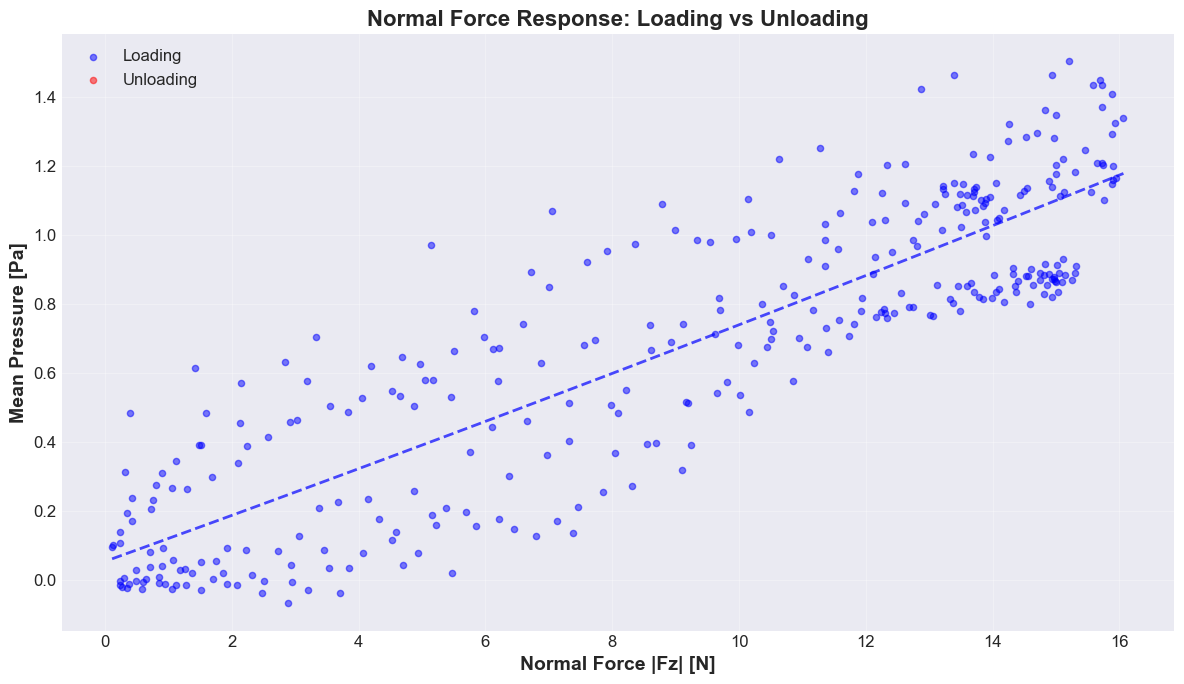

In [11]:
# === PLOT 1.1: Mean Pressure vs Fz (Loading & Unloading) ===
fig, ax = plt.subplots(figsize=(12, 7))

# Separate loading and unloading
loading = df1[df1['phase'] == 'loading']
unloading = df1[df1['phase'] == 'unloading']

# Plot
ax.scatter(loading['fz_abs'], loading['mean_pressure'], 
           alpha=0.5, s=20, label='Loading', color='blue')
ax.scatter(unloading['fz_abs'], unloading['mean_pressure'], 
           alpha=0.5, s=20, label='Unloading', color='red')

# Add trend lines
z_load = np.polyfit(loading['fz_abs'], loading['mean_pressure'], 2)
p_load = np.poly1d(z_load)
fz_range = np.linspace(loading['fz_abs'].min(), loading['fz_abs'].max(), 100)
ax.plot(fz_range, p_load(fz_range), '--', color='blue', linewidth=2, alpha=0.7)

if len(unloading) > 0:
    z_unload = np.polyfit(unloading['fz_abs'], unloading['mean_pressure'], 2)
    p_unload = np.poly1d(z_unload)
    fz_range_unload = np.linspace(unloading['fz_abs'].min(), unloading['fz_abs'].max(), 100)
    ax.plot(fz_range_unload, p_unload(fz_range_unload), '--', color='red', linewidth=2, alpha=0.7)

ax.set_xlabel('Normal Force |Fz| [N]', fontsize=14, fontweight='bold')
ax.set_ylabel('Mean Pressure [Pa]', fontsize=14, fontweight='bold')
ax.set_title('Normal Force Response: Loading vs Unloading', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate hysteresis
if len(unloading) > 0:
    hysteresis = np.mean(np.abs(loading['mean_pressure'].mean() - unloading['mean_pressure'].mean()))
    print(f"Average hysteresis: {hysteresis:.4f} Pa")

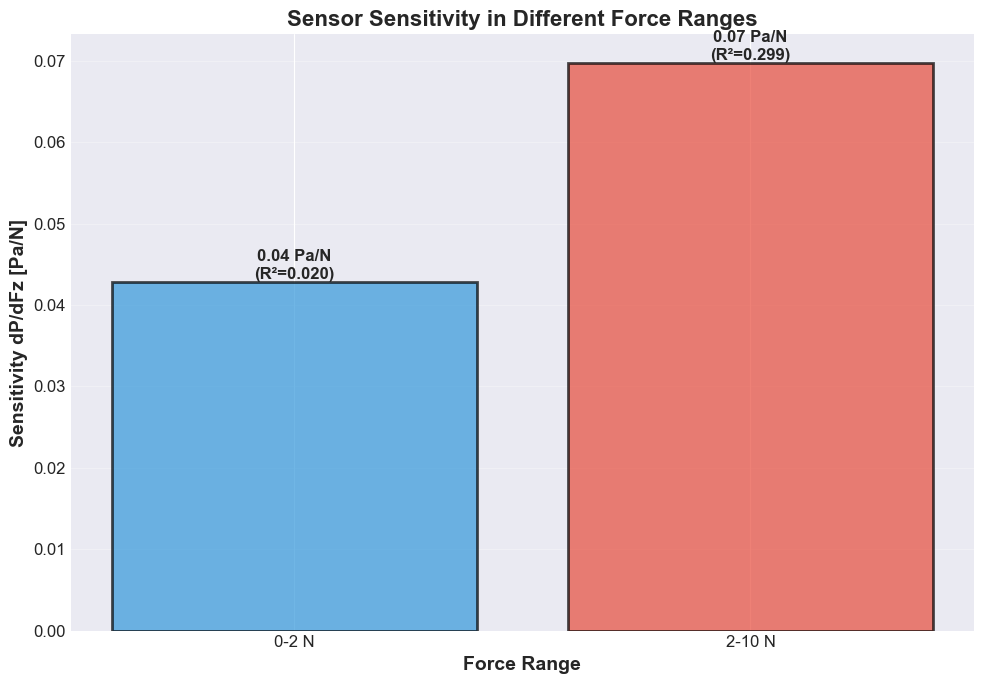

Low range (0-2 N) sensitivity: 0.043 Pa/N (R² = 0.020)
High range (2-10 N) sensitivity: 0.070 Pa/N (R² = 0.299)


In [12]:
# === PLOT 1.2: Sensitivity (dP/dFz) in Two Ranges ===
# Calculate sensitivity in 0-2 N and 2-10 N ranges
low_range = df1[(df1['fz_abs'] >= 0) & (df1['fz_abs'] <= 2)]
high_range = df1[(df1['fz_abs'] > 2) & (df1['fz_abs'] <= 10)]

# Linear fit to get slope
if len(low_range) > 10:
    slope_low, intercept_low, r_low, _, _ = stats.linregress(low_range['fz_abs'], low_range['mean_pressure'])
else:
    slope_low = 0
    r_low = 0

if len(high_range) > 10:
    slope_high, intercept_high, r_high, _, _ = stats.linregress(high_range['fz_abs'], high_range['mean_pressure'])
else:
    slope_high = 0
    r_high = 0

# Bar plot
fig, ax = plt.subplots(figsize=(10, 7))
ranges = ['0-2 N', '2-10 N']
sensitivities = [slope_low, slope_high]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(ranges, sensitivities, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, sens) in enumerate(zip(bars, sensitivities)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{sens:.2f} Pa/N\n(R²={[r_low**2, r_high**2][i]:.3f})',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Sensitivity dP/dFz [Pa/N]', fontsize=14, fontweight='bold')
ax.set_xlabel('Force Range', fontsize=14, fontweight='bold')
ax.set_title('Sensor Sensitivity in Different Force Ranges', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Low range (0-2 N) sensitivity: {slope_low:.3f} Pa/N (R² = {r_low**2:.3f})")
print(f"High range (2-10 N) sensitivity: {slope_high:.3f} Pa/N (R² = {r_high**2:.3f})")

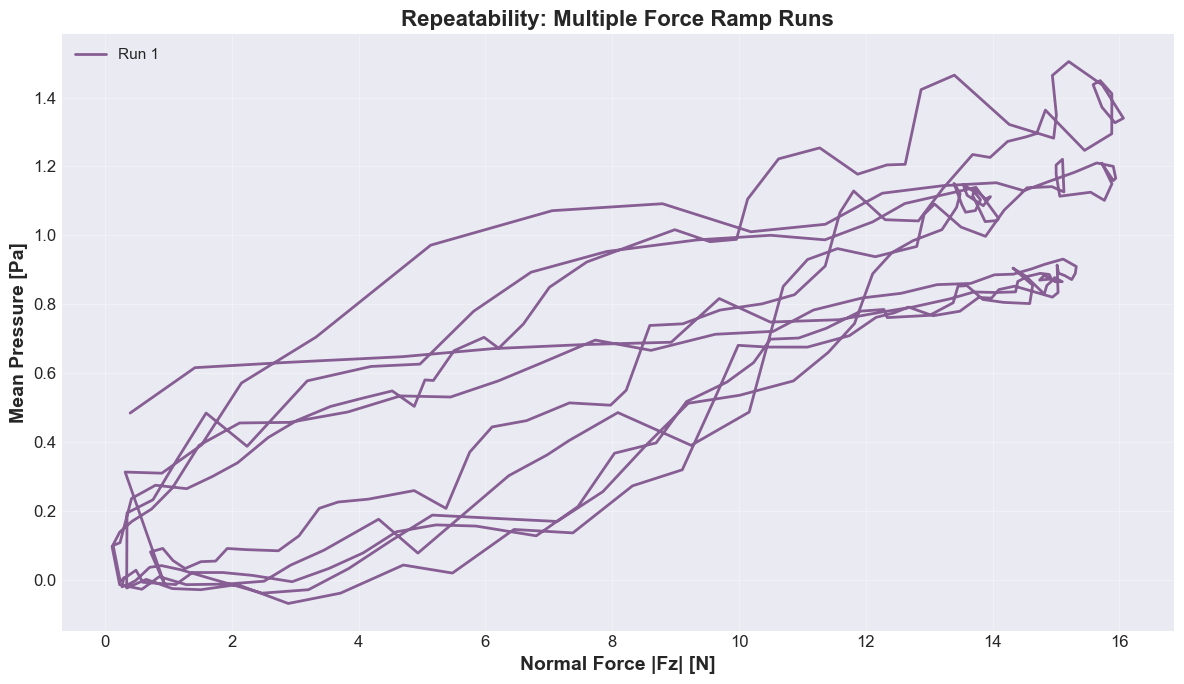

Coefficient of variation at 5.0N: 72.39%


In [13]:
# === PLOT 1.3: Repeatability (Overlay of Multiple Runs) ===
# Note: This assumes you can identify different runs in your data
# If runs are sequential, you can split by time gaps

# Detect runs based on force resets (when force drops significantly)
force_resets = np.where(np.diff(df1['fz_abs']) < -3)[0]
run_indices = np.split(df1.index, force_resets + 1)

fig, ax = plt.subplots(figsize=(12, 7))

# Plot first 5 runs (or fewer if not available)
colors = plt.cm.viridis(np.linspace(0, 1, min(5, len(run_indices))))
for i, run_idx in enumerate(run_indices[:5]):
    run_data = df1.loc[run_idx]
    if len(run_data) > 10:  # Only plot runs with sufficient data
        ax.plot(run_data['fz_abs'], run_data['mean_pressure'], 
                alpha=0.6, linewidth=2, label=f'Run {i+1}', color=colors[i])

ax.set_xlabel('Normal Force |Fz| [N]', fontsize=14, fontweight='bold')
ax.set_ylabel('Mean Pressure [Pa]', fontsize=14, fontweight='bold')
ax.set_title('Repeatability: Multiple Force Ramp Runs', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate repeatability metric (coefficient of variation at fixed force)
target_force = 5.0  # N
tolerance = 0.5  # N
samples_at_force = df1[(df1['fz_abs'] >= target_force - tolerance) & 
                       (df1['fz_abs'] <= target_force + tolerance)]
if len(samples_at_force) > 0:
    cv = (samples_at_force['mean_pressure'].std() / samples_at_force['mean_pressure'].mean()) * 100
    print(f"Coefficient of variation at {target_force}N: {cv:.2f}%")

---
## 2) Shear Response and Directionality
**Experiment:** Apply constant Fz (2N, 5N, 8N) and sweep shear in +x, -x, +y, -y.

**Plots:**
- Pressure gradient features vs shear: (b_right - b_left) vs Fx and (b_top - b_bottom) vs Fy
- Cross-coupling: predicted Fx feature vs Fy and vice versa

In [14]:
# === DATA LOADING ===
# Modify this path to your shear response dataset
data_path_2 = r"C:\Users\aurir\OneDrive - epfl.ch\Thesis- Biorobotics Lab\train_validation_test_data\test_data_v5.1092.csv"

# Load data
df2 = pd.read_csv(data_path_2)
print(f"Loaded {len(df2)} samples")
print(f"Fx range: {df2['fx'].min():.2f} to {df2['fx'].max():.2f} N")
print(f"Fy range: {df2['fy'].min():.2f} to {df2['fy'].max():.2f} N")
df2.head()

Loaded 0 samples
Fx range: nan to nan N
Fy range: nan to nan N


,t,b1,b2,b3,b4,b5,b6,x,y,fx,fy,fz,tx,ty,tz


In [15]:
# === PREPROCESSING ===
# Filter out artificial no-contact values (-999)
print(f"Total samples before filtering: {len(df2)}")
df2 = df2[(df2['fz'] != -999) & (df2['fx'] != -999) & (df2['fy'] != -999)]
print(f"Total samples after filtering -999: {len(df2)}")

# Define barometer layout (adjust based on your sensor geometry)
# Assuming: b1,b2 are left; b3,b4 are right; b1,b3 are top; b2,b4 are bottom
# Modify these assignments based on actual sensor layout

# Lateral gradient (left-right)
df2['b_left'] = (df2['b1'] + df2['b2']) / 2
df2['b_right'] = (df2['b3'] + df2['b4']) / 2
df2['gradient_x'] = df2['b_right'] - df2['b_left']

# Longitudinal gradient (top-bottom)
df2['b_top'] = (df2['b1'] + df2['b3']) / 2
df2['b_bottom'] = (df2['b2'] + df2['b4']) / 2
df2['gradient_y'] = df2['b_top'] - df2['b_bottom']

print("Gradient features calculated")

Total samples before filtering: 0
Total samples after filtering -999: 0
Gradient features calculated


TypeError: expected non-empty vector for x

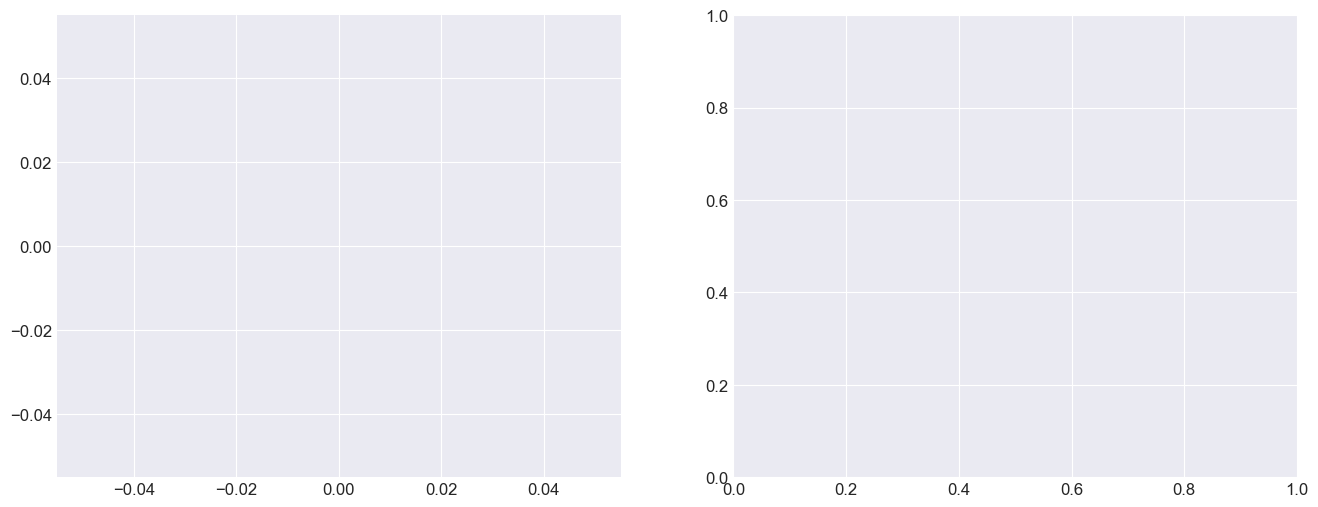

In [16]:
# === PLOT 2.1: Pressure Gradient vs Shear Forces ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: gradient_x vs Fx
axes[0].scatter(df2['fx'], df2['gradient_x'], alpha=0.5, s=30, c=np.abs(df2['fz']), 
                cmap='viridis', edgecolors='black', linewidth=0.5)
# Fit line
z = np.polyfit(df2['fx'], df2['gradient_x'], 1)
p = np.poly1d(z)
fx_range = np.linspace(df2['fx'].min(), df2['fx'].max(), 100)
axes[0].plot(fx_range, p(fx_range), 'r--', linewidth=3, label=f'Fit: y={z[0]:.2f}x+{z[1]:.2f}')
axes[0].set_xlabel('Shear Force Fx [N]', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Pressure Gradient (b_right - b_left) [Pa]', fontsize=13, fontweight='bold')
axes[0].set_title('X-Axis Shear Response', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar1.set_label('|Fz| [N]', fontsize=11)

# Plot 2: gradient_y vs Fy
axes[1].scatter(df2['fy'], df2['gradient_y'], alpha=0.5, s=30, c=np.abs(df2['fz']), 
                cmap='plasma', edgecolors='black', linewidth=0.5)
# Fit line
z2 = np.polyfit(df2['fy'], df2['gradient_y'], 1)
p2 = np.poly1d(z2)
fy_range = np.linspace(df2['fy'].min(), df2['fy'].max(), 100)
axes[1].plot(fy_range, p2(fy_range), 'r--', linewidth=3, label=f'Fit: y={z2[0]:.2f}x+{z2[1]:.2f}')
axes[1].set_xlabel('Shear Force Fy [N]', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Pressure Gradient (b_top - b_bottom) [Pa]', fontsize=13, fontweight='bold')
axes[1].set_title('Y-Axis Shear Response', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar2.set_label('|Fz| [N]', fontsize=11)

plt.tight_layout()
plt.show()

# Calculate correlation
corr_fx = np.corrcoef(df2['fx'], df2['gradient_x'])[0, 1]
corr_fy = np.corrcoef(df2['fy'], df2['gradient_y'])[0, 1]
print(f"Correlation (Fx, gradient_x): {corr_fx:.3f}")
print(f"Correlation (Fy, gradient_y): {corr_fy:.3f}")

In [ ]:
# === PLOT 2.2: Cross-Coupling Analysis ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Fx feature (gradient_x) vs Fy (should be uncoupled)
axes[0].scatter(df2['fy'], df2['gradient_x'], alpha=0.5, s=30, c='coral', edgecolors='black', linewidth=0.5)
z_cross1 = np.polyfit(df2['fy'], df2['gradient_x'], 1)
p_cross1 = np.poly1d(z_cross1)
axes[0].plot(fy_range, p_cross1(fy_range), 'k--', linewidth=2, alpha=0.7, label=f'Slope: {z_cross1[0]:.4f}')
axes[0].set_xlabel('Shear Force Fy [N]', fontsize=13, fontweight='bold')
axes[0].set_ylabel('X-Gradient Feature [Pa]', fontsize=13, fontweight='bold')
axes[0].set_title('Cross-Coupling: X-Feature vs Fy (Should be ~0)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Fy feature (gradient_y) vs Fx (should be uncoupled)
axes[1].scatter(df2['fx'], df2['gradient_y'], alpha=0.5, s=30, c='skyblue', edgecolors='black', linewidth=0.5)
z_cross2 = np.polyfit(df2['fx'], df2['gradient_y'], 1)
p_cross2 = np.poly1d(z_cross2)
axes[1].plot(fx_range, p_cross2(fx_range), 'k--', linewidth=2, alpha=0.7, label=f'Slope: {z_cross2[0]:.4f}')
axes[1].set_xlabel('Shear Force Fx [N]', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Y-Gradient Feature [Pa]', fontsize=13, fontweight='bold')
axes[1].set_title('Cross-Coupling: Y-Feature vs Fx (Should be ~0)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cross-coupling metrics
cross_corr_1 = np.corrcoef(df2['fy'], df2['gradient_x'])[0, 1]
cross_corr_2 = np.corrcoef(df2['fx'], df2['gradient_y'])[0, 1]
print(f"Cross-correlation (Fy vs X-gradient): {cross_corr_1:.4f} (ideal: 0)")
print(f"Cross-correlation (Fx vs Y-gradient): {cross_corr_2:.4f} (ideal: 0)")
print(f"Decoupling quality: {(1 - abs(cross_corr_1) - abs(cross_corr_2))*100:.1f}%")

---
## 3) Contact Localization
**Experiment:** Tap a grid of points (5×3 or 7×3) at fixed Fz (~3N).

**Plots:**
- True (x,y) grid vs estimated (x,y) using pressure centroid
- Localization error heatmap
- Error vs force level

In [ ]:
# === DATA LOADING ===
# Modify this path to your contact localization dataset
data_path_3 = r"C:\Users\aurir\OneDrive - epfl.ch\Thesis- Biorobotics Lab\train_validation_test_data\localization_data.csv"

# Load data
df3 = pd.read_csv(data_path_3)
print(f"Loaded {len(df3)} samples")
print(f"Position range X: {df3['x'].min():.2f} to {df3['x'].max():.2f}")
print(f"Position range Y: {df3['y'].min():.2f} to {df3['y'].max():.2f}")
df3.head()

In [ ]:
# === PREPROCESSING: Calculate Pressure Centroid ===
# Filter out artificial no-contact values (-999)
print(f"Total samples before filtering: {len(df3)}")
df3 = df3[(df3['fz'] != -999) & (df3['fx'] != -999) & (df3['fy'] != -999)]
print(f"Total samples after filtering -999: {len(df3)}")

# Assume barometer positions (modify based on your sensor geometry)
# Example layout: 2x3 grid
barometer_positions = {
    'b1': (0, 0),
    'b2': (0, 1),
    'b3': (1, 0),
    'b4': (1, 1),
    'b5': (0.5, 0),
    'b6': (0.5, 1)
}

def calculate_centroid(row):
    """Calculate pressure-weighted centroid"""
    total_pressure = 0
    weighted_x = 0
    weighted_y = 0
    
    for baro, (bx, by) in barometer_positions.items():
        p = row[baro]
        if p > 0:  # Only positive pressures
            total_pressure += p
            weighted_x += p * bx
            weighted_y += p * by
    
    if total_pressure > 0:
        return weighted_x / total_pressure, weighted_y / total_pressure
    else:
        return np.nan, np.nan

# Calculate estimated positions
df3[['x_est', 'y_est']] = df3.apply(lambda row: calculate_centroid(row), axis=1, result_type='expand')

# Remove NaN values
df3 = df3.dropna(subset=['x_est', 'y_est'])

# Calculate errors
df3['error_x'] = df3['x'] - df3['x_est']
df3['error_y'] = df3['y'] - df3['y_est']
df3['error_euclidean'] = np.sqrt(df3['error_x']**2 + df3['error_y']**2)

print(f"Mean localization error: {df3['error_euclidean'].mean():.3f} units")
print(f"Std localization error: {df3['error_euclidean'].std():.3f} units")

In [ ]:
# === PLOT 3.1: True vs Estimated Positions ===
fig, ax = plt.subplots(figsize=(10, 10))

# Plot true positions
ax.scatter(df3['x'], df3['y'], s=150, alpha=0.6, c='blue', marker='o', 
           edgecolors='black', linewidth=2, label='True Position')

# Plot estimated positions
ax.scatter(df3['x_est'], df3['y_est'], s=150, alpha=0.6, c='red', marker='x', 
           linewidth=3, label='Estimated Position')

# Draw error vectors
for idx, row in df3.iterrows():
    ax.arrow(row['x'], row['y'], row['x_est']-row['x'], row['y_est']-row['y'], 
             head_width=0.3, head_length=0.2, fc='gray', ec='gray', alpha=0.3, linewidth=1)

ax.set_xlabel('X Position', fontsize=14, fontweight='bold')
ax.set_ylabel('Y Position', fontsize=14, fontweight='bold')
ax.set_title('Contact Localization: True vs Estimated Positions', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [ ]:
# === PLOT 3.2: Localization Error Heatmap ===
# Create grid for interpolation
grid_x, grid_y = np.mgrid[df3['x'].min():df3['x'].max():100j, 
                           df3['y'].min():df3['y'].max():100j]

# Interpolate error over grid
grid_error = griddata((df3['x'], df3['y']), df3['error_euclidean'], 
                      (grid_x, grid_y), method='cubic')

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.contourf(grid_x, grid_y, grid_error, levels=20, cmap='RdYlGn_r')
ax.scatter(df3['x'], df3['y'], c='black', s=100, marker='o', 
           edgecolors='white', linewidth=2, label='Contact Points')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Localization Error', fontsize=13, fontweight='bold')

ax.set_xlabel('X Position', fontsize=14, fontweight='bold')
ax.set_ylabel('Y Position', fontsize=14, fontweight='bold')
ax.set_title('Localization Error Heatmap', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [ ]:
# === PLOT 3.3: Error vs Force Level ===
# Bin force into levels
df3['fz_abs'] = np.abs(df3['fz'])
df3['force_level'] = pd.cut(df3['fz_abs'], bins=[0, 2, 5, 10], labels=['Low (0-2N)', 'Medium (2-5N)', 'High (5-10N)'])

fig, ax = plt.subplots(figsize=(12, 7))

# Box plot
df3.boxplot(column='error_euclidean', by='force_level', ax=ax, patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(linewidth=1.5),
            capprops=dict(linewidth=1.5))

ax.set_xlabel('Force Level', fontsize=14, fontweight='bold')
ax.set_ylabel('Localization Error', fontsize=14, fontweight='bold')
ax.set_title('Localization Error vs Force Level', fontsize=16, fontweight='bold')
plt.suptitle('')  # Remove default title
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistics per level
print("\nError statistics by force level:")
print(df3.groupby('force_level')['error_euclidean'].describe())

---
## 4) Noise Floor and Resolution
**Experiment:** No-contact recording (60s), then constant contact at fixed Fz (~2N) for 60s.

**Plots:**
- Barometer signals over time (no-contact vs constant contact)
- Standard deviation per channel (bar plot)
- Minimum detectable force estimate

In [ ]:
# === DATA LOADING ===
# Modify this path to your noise characterization dataset
data_path_4 = r"C:\Users\aurir\OneDrive - epfl.ch\Thesis- Biorobotics Lab\train_validation_test_data\test_data_v5.1094.csv"

# Load data
df4 = pd.read_csv(data_path_4)
print(f"Loaded {len(df4)} samples")
df4.head()

Loaded 0 samples


,t,b1,b2,b3,b4,b5,b6,x,y,fx,fy,fz,tx,ty,tz


In [ ]:
# === PREPROCESSING ===
# Filter out artificial no-contact values (-999) - but keep genuine no-contact (close to 0)
print(f"Total samples before filtering: {len(df4)}")
df4 = df4[(df4['fz'] != -999) & (df4['fx'] != -999) & (df4['fy'] != -999)]
print(f"Total samples after filtering -999: {len(df4)}")

# Identify no-contact and contact periods based on force threshold
force_threshold = 0.5  # N
df4['contact'] = np.abs(df4['fz']) > force_threshold

# Create time axis (relative to start)
df4['time_rel'] = df4['t'] - df4['t'].iloc[0]

no_contact = df4[~df4['contact']]
with_contact = df4[df4['contact']]

print(f"No-contact samples: {len(no_contact)}")
print(f"With-contact samples: {len(with_contact)}")

Total samples before filtering: 0
Total samples after filtering -999: 0


IndexError: single positional indexer is out-of-bounds

In [ ]:
# === PLOT 4.1: Barometer Signals Over Time ===
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot all barometer channels
for baro in barometer_cols:
    axes[0].plot(no_contact['time_rel'], no_contact[baro], alpha=0.6, linewidth=1.5, label=baro)
    axes[1].plot(with_contact['time_rel'], with_contact[baro], alpha=0.6, linewidth=1.5, label=baro)

axes[0].set_ylabel('Pressure [Pa]', fontsize=13, fontweight='bold')
axes[0].set_title('No Contact - Noise Floor', fontsize=14, fontweight='bold')
axes[0].legend(ncol=6, fontsize=10, loc='upper right')
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Time [s]', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Pressure [Pa]', fontsize=13, fontweight='bold')
axes[1].set_title('Constant Contact', fontsize=14, fontweight='bold')
axes[1].legend(ncol=6, fontsize=10, loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# === PLOT 4.2: Standard Deviation per Channel ===
# Calculate std for each condition
std_no_contact = no_contact[barometer_cols].std()
std_with_contact = with_contact[barometer_cols].std()

fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(barometer_cols))
width = 0.35

bars1 = ax.bar(x - width/2, std_no_contact, width, label='No Contact', 
               color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, std_with_contact, width, label='With Contact', 
               color='coral', alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Barometer Channel', fontsize=14, fontweight='bold')
ax.set_ylabel('Standard Deviation [Pa]', fontsize=14, fontweight='bold')
ax.set_title('Noise Characterization: Standard Deviation per Channel', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(barometer_cols)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nNoise levels (no contact):")
print(std_no_contact)
print("\nAverage noise: {:.5f} Pa".format(std_no_contact.mean()))

In [ ]:
# === PLOT 4.3: Minimum Detectable Force ===
# Use sensitivity from experiment 1 (you may need to input this manually or load from previous analysis)
# For demonstration, we'll estimate from current data

# Calculate mean sensitivity (Pa/N) from contact data
if len(with_contact) > 0:
    mean_pressure_contact = with_contact[barometer_cols].mean(axis=1).mean()
    mean_force_contact = np.abs(with_contact['fz']).mean()
    sensitivity = mean_pressure_contact / mean_force_contact if mean_force_contact > 0 else 1
else:
    sensitivity = 1  # Default

# Minimum detectable force: 3× noise / sensitivity (3-sigma rule)
noise_level = std_no_contact.mean()
min_detectable_force = (3 * noise_level) / sensitivity

fig, ax = plt.subplots(figsize=(10, 7))

# Calculate SNR at different force levels
force_levels = np.linspace(0, 10, 100)
signal = force_levels * sensitivity
snr = signal / noise_level

ax.plot(force_levels, snr, linewidth=3, color='darkgreen', label='SNR')
ax.axhline(y=3, color='red', linestyle='--', linewidth=2, label='3-sigma threshold')
ax.axvline(x=min_detectable_force, color='orange', linestyle='--', linewidth=2, 
           label=f'Min detectable: {min_detectable_force:.3f} N')

ax.set_xlabel('Applied Force [N]', fontsize=14, fontweight='bold')
ax.set_ylabel('Signal-to-Noise Ratio', fontsize=14, fontweight='bold')
ax.set_title('Force Resolution: SNR vs Applied Force', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 10)
plt.tight_layout()
plt.show()

print(f"\nSensor sensitivity: {sensitivity:.3f} Pa/N")
print(f"Noise floor: {noise_level:.5f} Pa")
print(f"Minimum detectable force (3σ): {min_detectable_force:.4f} N")

---
## 5) Drift and Temperature Sensitivity
**Experiment:** No-contact for 10 minutes, then constant load for 10 minutes.

**Plots:**
- Baseline drift over time (before/after EMA drift removal)
- Pressure vs temperature correlation

In [ ]:
# === DATA LOADING ===
# Modify this path to your drift characterization dataset
data_path_5 = r"C:\Users\aurir\OneDrive - epfl.ch\Thesis- Biorobotics Lab\train_validation_test_data\drift_data.csv"

# Load data
df5 = pd.read_csv(data_path_5)
print(f"Loaded {len(df5)} samples")
df5.head()

In [ ]:
# === PREPROCESSING ===
# Filter out artificial no-contact values (-999)
print(f"Total samples before filtering: {len(df5)}")
df5 = df5[(df5['fz'] != -999) & (df5['fx'] != -999) & (df5['fy'] != -999)]
print(f"Total samples after filtering -999: {len(df5)}")

# Create relative time axis
df5['time_rel'] = df5['t'] - df5['t'].iloc[0]

# Calculate mean pressure
df5['mean_pressure'] = df5[barometer_cols].mean(axis=1)

# Apply EMA drift removal (exponential moving average)
alpha = 0.01  # Smoothing factor (adjust as needed)
df5['mean_pressure_ema'] = df5['mean_pressure'].ewm(alpha=alpha).mean()
df5['mean_pressure_corrected'] = df5['mean_pressure'] - df5['mean_pressure_ema']

print(f"Time range: {df5['time_rel'].min():.1f} to {df5['time_rel'].max():.1f} seconds")

In [ ]:
# === PLOT 5.1: Baseline Drift Over Time ===
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Raw signal
axes[0].plot(df5['time_rel'], df5['mean_pressure'], linewidth=1.5, 
             color='navy', alpha=0.7, label='Raw signal')
axes[0].plot(df5['time_rel'], df5['mean_pressure_ema'], linewidth=2, 
             color='red', alpha=0.8, label='EMA baseline')
axes[0].set_ylabel('Mean Pressure [Pa]', fontsize=13, fontweight='bold')
axes[0].set_title('Baseline Drift - Raw Signal', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Drift-corrected signal
axes[1].plot(df5['time_rel'], df5['mean_pressure_corrected'], linewidth=1.5, 
             color='green', alpha=0.7, label='Drift-corrected')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Time [s]', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Corrected Pressure [Pa]', fontsize=13, fontweight='bold')
axes[1].set_title('After EMA Drift Removal', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate drift rate
time_minutes = df5['time_rel'].max() / 60
total_drift = df5['mean_pressure'].iloc[-1] - df5['mean_pressure'].iloc[0]
drift_rate = total_drift / time_minutes
print(f"\nTotal drift: {total_drift:.4f} Pa over {time_minutes:.1f} minutes")
print(f"Drift rate: {drift_rate:.4f} Pa/min")

In [ ]:
# === PLOT 5.2: Pressure vs Temperature Correlation ===
# Check if temperature data exists (assuming columns t1-t6 for temperature sensors)
temp_cols = [col for col in df5.columns if col.startswith('t') and col[1:].isdigit()]

if len(temp_cols) > 0:
    # Calculate mean temperature
    df5['mean_temp'] = df5[temp_cols].mean(axis=1)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Scatter plot
    scatter = ax.scatter(df5['mean_temp'], df5['mean_pressure'], 
                        c=df5['time_rel'], cmap='viridis', 
                        s=30, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    # Fit linear regression
    z = np.polyfit(df5['mean_temp'], df5['mean_pressure'], 1)
    p = np.poly1d(z)
    temp_range = np.linspace(df5['mean_temp'].min(), df5['mean_temp'].max(), 100)
    ax.plot(temp_range, p(temp_range), 'r--', linewidth=3, 
            label=f'Fit: P = {z[0]:.2f}T + {z[1]:.2f}')
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Time [s]', fontsize=12, fontweight='bold')
    
    ax.set_xlabel('Mean Temperature [°C]', fontsize=14, fontweight='bold')
    ax.set_ylabel('Mean Pressure [Pa]', fontsize=14, fontweight='bold')
    ax.set_title('Pressure vs Temperature Correlation', fontsize=16, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation
    corr = np.corrcoef(df5['mean_temp'], df5['mean_pressure'])[0, 1]
    print(f"\nTemperature-Pressure correlation: {corr:.4f}")
    print(f"Temperature coefficient: {z[0]:.3f} Pa/°C")
else:
    print("No temperature data found in dataset. Skipping temperature correlation plot.")

---
## 6) Version or Material Comparison
**Experiment:** Run same normal-force test on 2 versions/materials.

**Plots:**
- Mean pressure vs Fz comparison
- Hysteresis metric comparison

In [ ]:
# === DATA LOADING ===
# Modify these paths to your version comparison datasets
data_path_6a = r"C:\Users\aurir\OneDrive - epfl.ch\Thesis- Biorobotics Lab\train_validation_test_data\version_a.csv"
data_path_6b = r"C:\Users\aurir\OneDrive - epfl.ch\Thesis- Biorobotics Lab\train_validation_test_data\version_b.csv"

# Load data
df6a = pd.read_csv(data_path_6a)
df6b = pd.read_csv(data_path_6b)

print(f"Version A: {len(df6a)} samples")
print(f"Version B: {len(df6b)} samples")

In [ ]:
# === PREPROCESSING ===
# Process both versions
for df, label in [(df6a, 'A'), (df6b, 'B')]:
    # Filter out artificial no-contact values (-999)
    initial_len = len(df)
    df_filtered = df[(df['fz'] != -999) & (df['fx'] != -999) & (df['fy'] != -999)]
    print(f"Version {label}: {initial_len} -> {len(df_filtered)} samples (removed {initial_len - len(df_filtered)} -999 values)")
    
    # Update the dataframe
    if label == 'A':
        df6a = df_filtered.copy()
    else:
        df6b = df_filtered.copy()

# Now process the filtered data
for df, label in [(df6a, 'A'), (df6b, 'B')]:
    df['mean_pressure'] = df[barometer_cols].mean(axis=1)
    df['fz_abs'] = np.abs(df['fz'])
    df['version'] = label
    
    # Detect loading/unloading
    df['fz_diff'] = df['fz_abs'].diff()
    df['phase'] = 'loading'
    df.loc[df['fz_diff'] < -0.1, 'phase'] = 'unloading'
    df['phase'] = df['phase'].replace('unloading', np.nan)
    df['phase'] = df['phase'].fillna(method='ffill')
    df['phase'] = df['phase'].fillna('loading')

print("Preprocessing complete")

In [ ]:
# === PLOT 6.1: Mean Pressure vs Fz Comparison ===
fig, ax = plt.subplots(figsize=(12, 7))

# Version A
ax.scatter(df6a['fz_abs'], df6a['mean_pressure'], 
           alpha=0.4, s=20, color='blue', label='Version A')
z_a = np.polyfit(df6a['fz_abs'], df6a['mean_pressure'], 2)
p_a = np.poly1d(z_a)
fz_range_a = np.linspace(df6a['fz_abs'].min(), df6a['fz_abs'].max(), 100)
ax.plot(fz_range_a, p_a(fz_range_a), 'b-', linewidth=3, alpha=0.8)

# Version B
ax.scatter(df6b['fz_abs'], df6b['mean_pressure'], 
           alpha=0.4, s=20, color='red', label='Version B')
z_b = np.polyfit(df6b['fz_abs'], df6b['mean_pressure'], 2)
p_b = np.poly1d(z_b)
fz_range_b = np.linspace(df6b['fz_abs'].min(), df6b['fz_abs'].max(), 100)
ax.plot(fz_range_b, p_b(fz_range_b), 'r-', linewidth=3, alpha=0.8)

ax.set_xlabel('Normal Force |Fz| [N]', fontsize=14, fontweight='bold')
ax.set_ylabel('Mean Pressure [Pa]', fontsize=14, fontweight='bold')
ax.set_title('Version Comparison: Force Response', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate sensitivities
slope_a, _, r_a, _, _ = stats.linregress(df6a['fz_abs'], df6a['mean_pressure'])
slope_b, _, r_b, _, _ = stats.linregress(df6b['fz_abs'], df6b['mean_pressure'])
print(f"\nVersion A sensitivity: {slope_a:.3f} Pa/N (R² = {r_a**2:.3f})")
print(f"Version B sensitivity: {slope_b:.3f} Pa/N (R² = {r_b**2:.3f})")
print(f"Relative difference: {abs(slope_a - slope_b)/slope_a * 100:.1f}%")

In [ ]:
# === PLOT 6.2: Hysteresis Comparison ===
# Calculate hysteresis for each version
def calculate_hysteresis(df):
    """Calculate hysteresis as area between loading and unloading curves"""
    loading = df[df['phase'] == 'loading']
    unloading = df[df['phase'] == 'unloading']
    
    if len(loading) > 0 and len(unloading) > 0:
        # Average difference at common force levels
        common_forces = np.linspace(max(loading['fz_abs'].min(), unloading['fz_abs'].min()),
                                   min(loading['fz_abs'].max(), unloading['fz_abs'].max()),
                                   50)
        
        p_load_interp = np.interp(common_forces, loading['fz_abs'], loading['mean_pressure'])
        p_unload_interp = np.interp(common_forces, unloading['fz_abs'], unloading['mean_pressure'])
        
        hysteresis = np.mean(np.abs(p_load_interp - p_unload_interp))
        return hysteresis
    else:
        return 0

hyst_a = calculate_hysteresis(df6a)
hyst_b = calculate_hysteresis(df6b)

# Bar plot
fig, ax = plt.subplots(figsize=(10, 7))
versions = ['Version A', 'Version B']
hysteresis_values = [hyst_a, hyst_b]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(versions, hysteresis_values, color=colors, alpha=0.7, 
              edgecolor='black', linewidth=2)

# Add value labels
for bar, val in zip(bars, hysteresis_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f} Pa', ha='center', va='bottom', 
            fontsize=13, fontweight='bold')

ax.set_ylabel('Hysteresis [Pa]', fontsize=14, fontweight='bold')
ax.set_title('Hysteresis Comparison Between Versions', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nVersion A hysteresis: {hyst_a:.4f} Pa")
print(f"Version B hysteresis: {hyst_b:.4f} Pa")
if hyst_a > 0:
    print(f"Relative difference: {abs(hyst_a - hyst_b)/hyst_a * 100:.1f}%")

---
## Summary and Export
All analyses complete! You can now save figures or export results.

In [ ]:
# Optional: Save all figures
# Uncomment to enable automatic figure saving

# import os
# output_dir = r"C:\Users\aurir\OneDrive - epfl.ch\Thesis- Biorobotics Lab\figures"
# os.makedirs(output_dir, exist_ok=True)

# # Save figures with descriptive names
# figure_names = [
#     "1_normal_force_response.png",
#     "2_sensitivity_comparison.png",
#     "3_repeatability.png",
#     "4_shear_response.png",
#     "5_cross_coupling.png",
#     "6_localization_accuracy.png",
#     "7_error_heatmap.png",
#     "8_error_vs_force.png",
#     "9_noise_signals.png",
#     "10_noise_std.png",
#     "11_min_detectable_force.png",
#     "12_drift_analysis.png",
#     "13_temp_correlation.png",
#     "14_version_comparison.png",
#     "15_hysteresis_comparison.png"
# ]

print("Analysis complete! Review the plots above.")